In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
np.random.seed(42)

In [3]:
def load_dataset():
    """
    Loads and preprocesses the MNIST dataset.

    Returns:
    - Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Training and test data and labels.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = (x_train-127.5)/127.5, (x_test-127.5)/127.5
    x_train = x_train.reshape((-1, 28, 28, 1))
    x_test = x_test.reshape((-1, 28, 28, 1))
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset()

In [4]:
MODEL_OUTPUT_PATH = r'C:\Users\Admin\Documents\cgan'
LATENT_DIM = 100

def define_generator():
    """
    Defines the generator model for generating images.

    Returns:
    - tf.keras.models.Model: Generator model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=LATENT_DIM),
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(momentum=0.8),
        tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh')
    ])

    z = tf.keras.layers.Input(shape=(LATENT_DIM,))
    label = tf.keras.layers.Input(shape=(1,), dtype='uint8')
    label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=LATENT_DIM)(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    combined = tf.keras.layers.multiply([z, label_embed])

    img = model(combined)

    return tf.keras.models.Model([z, label], img)

def get_g_model():
    """
    Retrieves the generator model.

    Returns:
    - tf.keras.models.Model: Generator model.
    """
    g_model = define_generator()
    g_model.summary()
    if not os.path.exists(os.path.join(MODEL_OUTPUT_PATH, 'diagrams')): 
        os.makedirs(os.path.join(MODEL_OUTPUT_PATH, 'diagrams'))
    tf.keras.utils.plot_model(
        g_model, to_file=os.path.join(MODEL_OUTPUT_PATH, 'diagrams/generator.png'), show_shapes=True, show_layer_names=True)
    return g_model

g_model = get_g_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
______________________________________________________________________________________________

In [7]:
def define_discriminator():
    """
    Defines the discriminator model for distinguishing real from fake images.

    Returns:
    - tf.keras.models.Model: Discriminator model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), 2, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3, 3), 2, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    img = tf.keras.layers.Input(shape=(28, 28, 1))
    label = tf.keras.layers.Input(shape=(1,))
    label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28, 28)))(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
    prediction = model(concatenated)
    return tf.keras.models.Model([img, label], prediction)

def get_d_model():
    """
    Retrieves the discriminator model.

    Returns:
    - tf.keras.models.Model: Discriminator model.
    """
    d_model = define_discriminator()
    d_model.summary()
    if not os.path.exists(os.path.join(MODEL_OUTPUT_PATH, 'diagrams')): 
        os.makedirs(os.path.join(MODEL_OUTPUT_PATH, 'diagrams'))
    tf.keras.utils.plot_model(
        d_model, to_file=os.path.join(MODEL_OUTPUT_PATH, 'diagrams/discriminator.png'), show_shapes=True, show_layer_names=True)
    return d_model

d_model = get_d_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 784)       7840        input_5[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           flatten_2[0][0]                  
____________________________________________________________________________________________

In [9]:
def get_cgan_model():
    """
    Retrieves the CGAN model, discriminator, and generator models.

    Returns:
    - Tuple[tf.keras.models.Model, tf.keras.models.Model, tf.keras.models.Model]: CGAN, discriminator, and generator models.
    """

    d_model.compile(loss='binary_crossentropy', metrics=[
        'accuracy'], optimizer='adam')

    z = tf.keras.layers.Input(shape=(100,))
    label = tf.keras.layers.Input(shape=(1,))
    img = g_model([z, label])

    d_model.trainable = False
    prediction = d_model([img, label])
    cgan = tf.keras.models.Model([z, label], prediction)
    cgan.compile(loss='binary_crossentropy',
                 optimizer='adam', metrics=['accuracy'])
    cgan.summary()
    if not os.path.exists(os.path.join(MODEL_OUTPUT_PATH, 'diagrams')): 
        os.makedirs(os.path.join(MODEL_OUTPUT_PATH, 'diagrams'))
    tf.keras.utils.plot_model(
        cgan, to_file=os.path.join(MODEL_OUTPUT_PATH, 'diagrams/cgan.png'), show_shapes=True, show_layer_names=True)
    return cgan, d_model, g_model

cgan, d_model, g_model = get_cgan_model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 28, 28, 1)    857193      input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1)            1633601     model_1[0][0]              

Losses(d,g): 0.7397083044052124 [0.21311934292316437, 1.0]


C:\Users\Admin\miniconda3\envs\gan\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


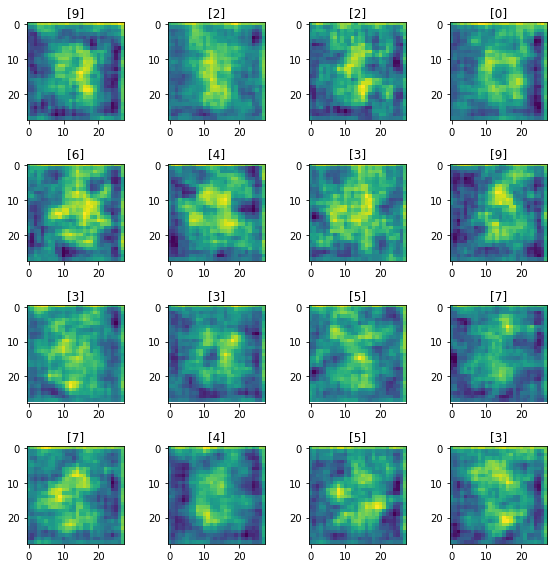

Losses(d,g): 0.023958769161254168 [9.21164608001709, 0.0]


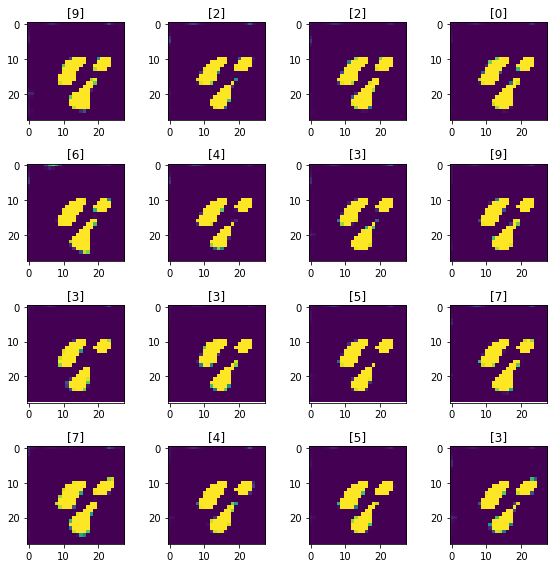

Losses(d,g): 0.149507537484169 [4.093067169189453, 0.0234375]


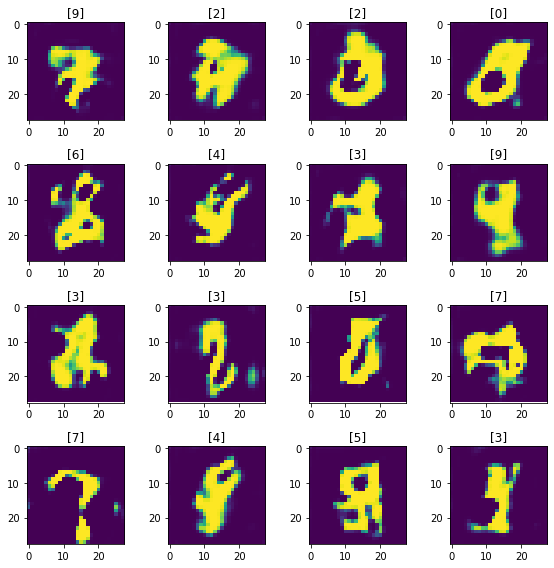

Losses(d,g): 0.3511202037334442 [2.2988295555114746, 0.1328125]


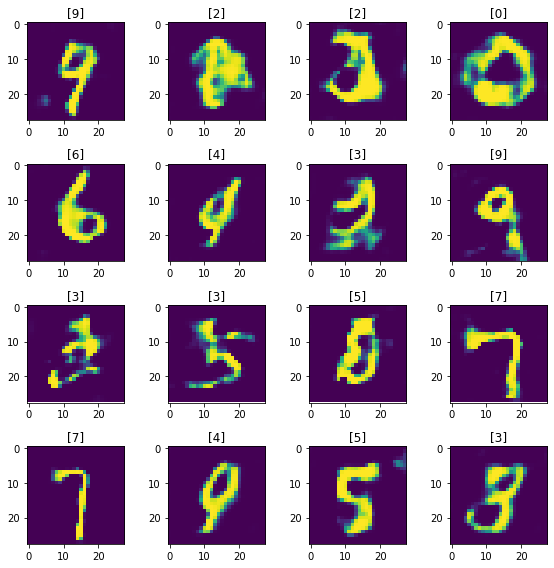

Losses(d,g): 0.4024212658405304 [1.9464740753173828, 0.1484375]


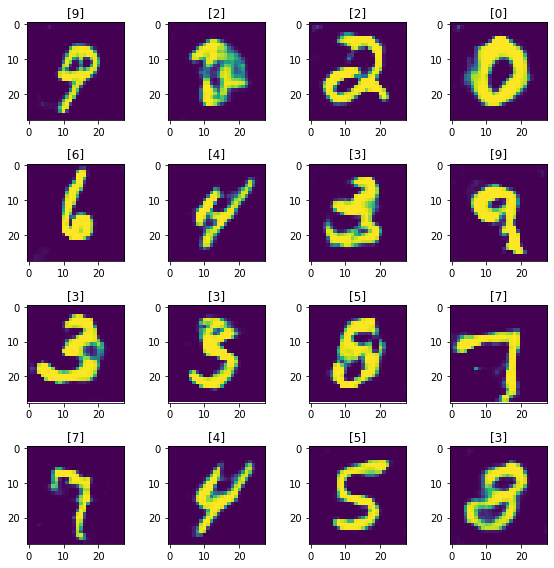

Losses(d,g): 0.3544042259454727 [1.769923210144043, 0.1796875]


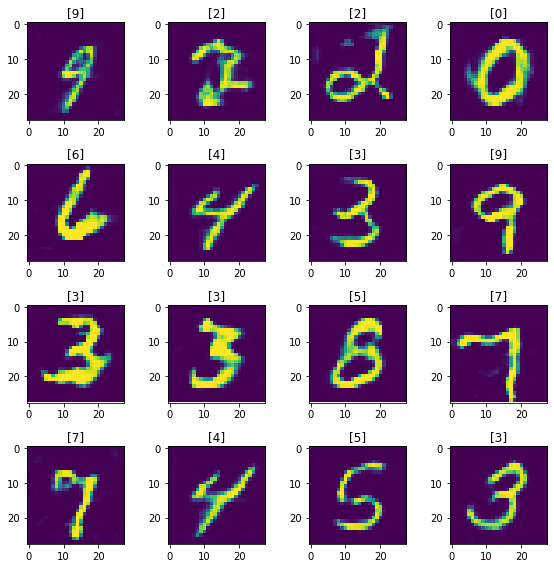

Losses(d,g): 0.4735051840543747 [1.4535340070724487, 0.1484375]


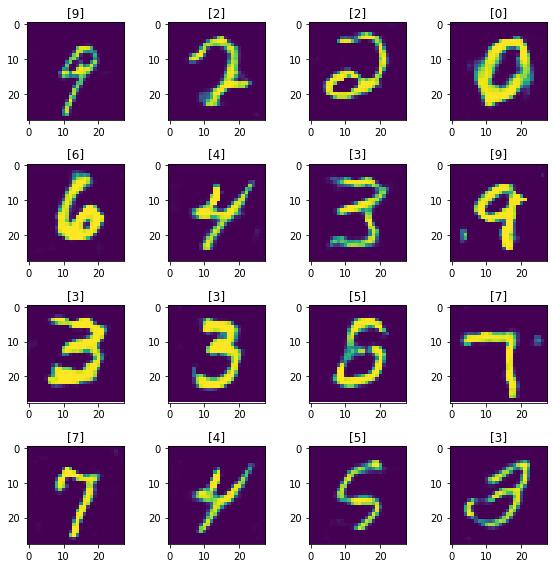

Losses(d,g): 0.5444574952125549 [1.7050817012786865, 0.2421875]


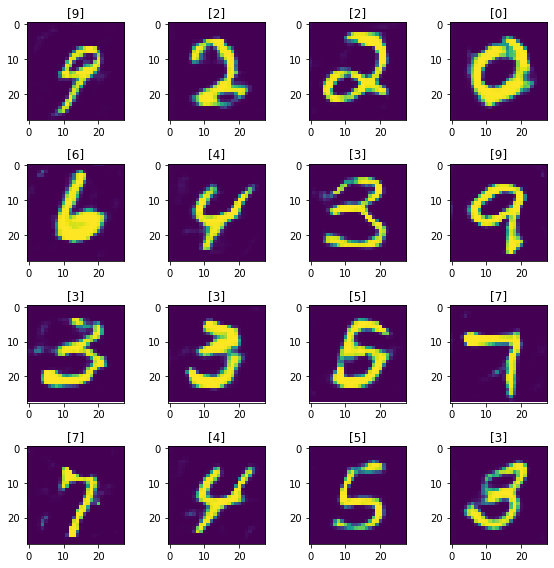

Losses(d,g): 0.5424831509590149 [1.1138355731964111, 0.2734375]


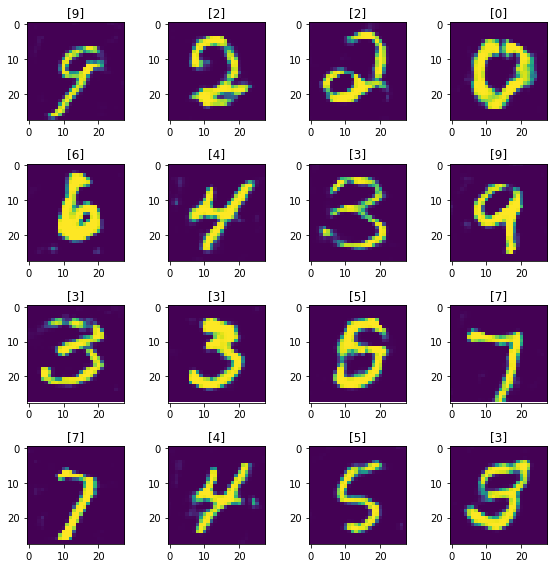

Losses(d,g): 0.5506665110588074 [1.1299967765808105, 0.21875]


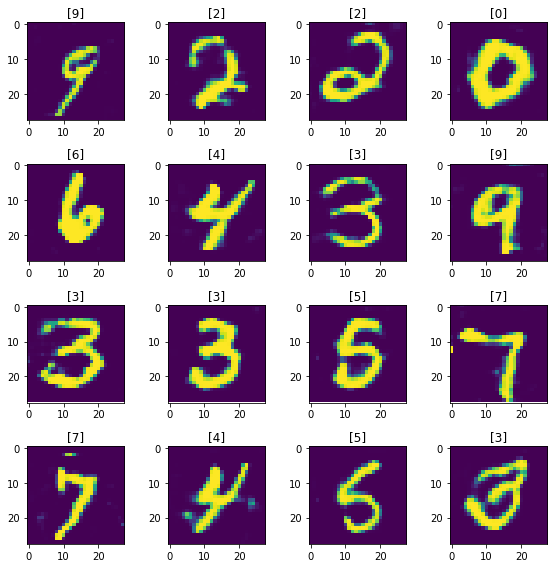

Losses(d,g): 0.4899752587080002 [1.2135463953018188, 0.2578125]


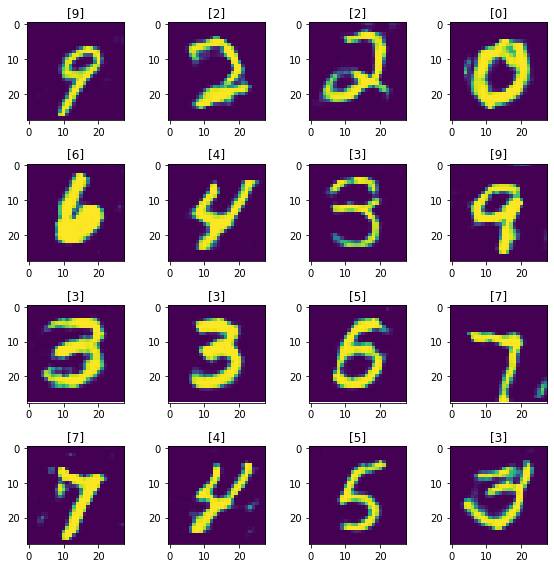

Losses(d,g): 0.5893253684043884 [0.9816552400588989, 0.265625]


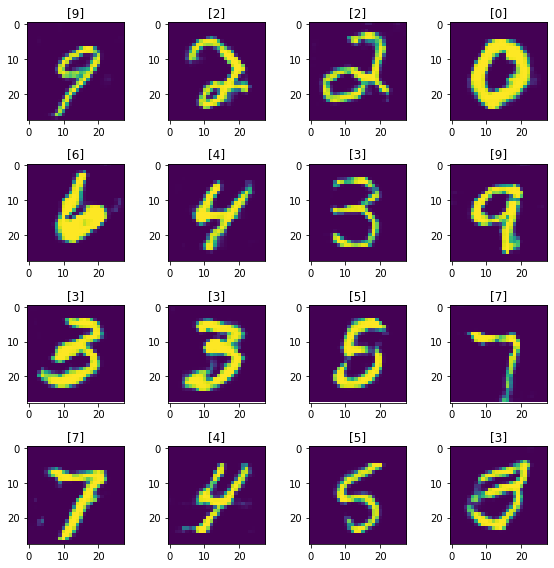

Losses(d,g): 0.5752000510692596 [1.1467071771621704, 0.2578125]


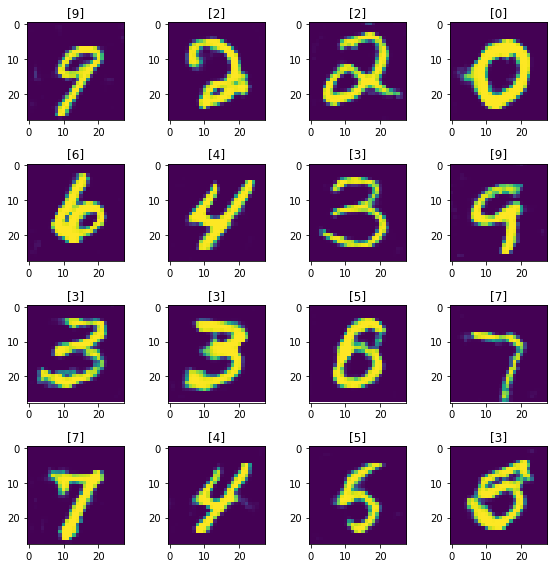

Losses(d,g): 0.5702449679374695 [1.1444132328033447, 0.25]


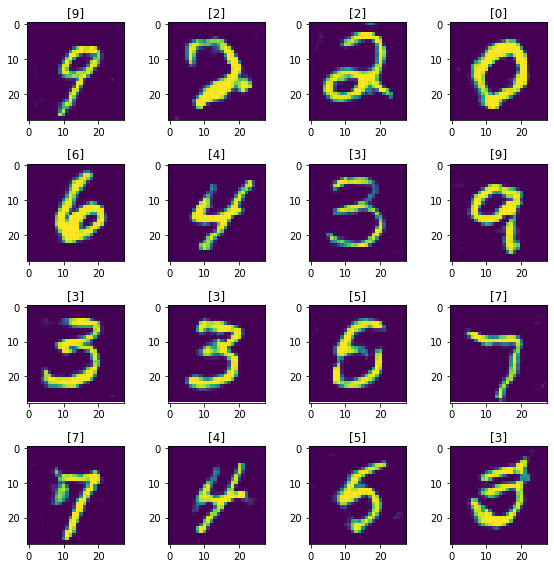

Losses(d,g): 0.6015401184558868 [1.0469939708709717, 0.3203125]


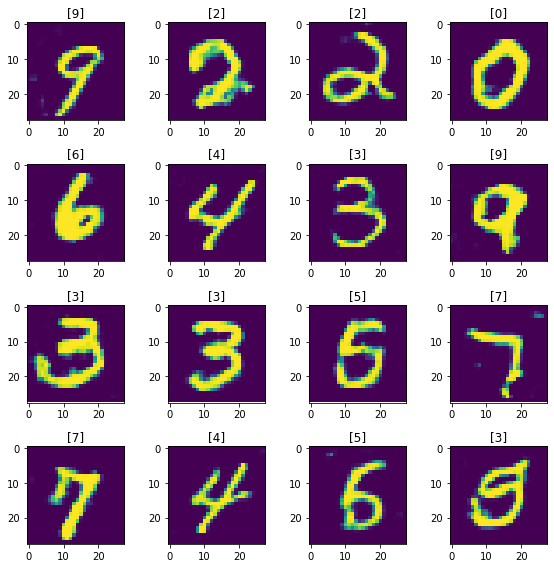

Losses(d,g): 0.5347719788551331 [1.1738770008087158, 0.2109375]


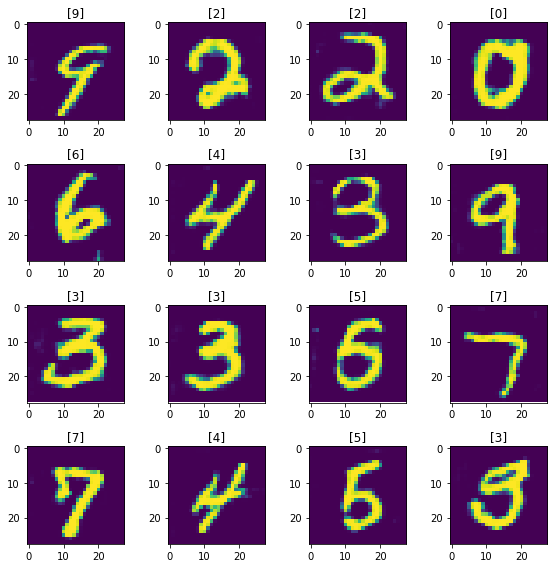

In [10]:
EPOCHS = 15005
BATCH_SIZE = 128
SAVE_INTERVAL = 1000

def plot_image(images, labels, rows, cols):
    """
    Plots images in a grid.

    Parameters:
    - images (np.ndarray): Images to be plotted.
    - labels (np.ndarray): Corresponding labels for each image.
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    """
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, cols*rows + 1):
        img = images[i-1]
        ax = fig.add_subplot(rows, cols, i)
        ax.title.set_text(labels[i-1])
        plt.imshow(img.reshape((28, 28)))
    fig.tight_layout()
    plt.show()

def train_model():
    """
    Trains the CGAN model on the MNIST dataset.
    """
    valid = np.ones((BATCH_SIZE, 1))
    fake = np.zeros((BATCH_SIZE, 1))

    losses = {"G": [], "D": []}

    samples_test = np.random.normal(0, 1, (16, 100))
    labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))

    for epoch in range(EPOCHS):
        idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
        real_imgs, labels = x_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
        fake_imgs = g_model.predict([noise, labels])

        # train discriminator
        d_model.trainable = True
        d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
        d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        d_model.trainable = False

        z = np.random.normal(0, 1, size=(BATCH_SIZE, 100))
        labels = np.random.randint(0, 10, BATCH_SIZE).reshape((-1, 1))

        # train generator
        g_loss = cgan.train_on_batch([z, labels], valid)

        losses["G"].append(g_loss)
        losses["D"].append(d_loss)

        if epoch % SAVE_INTERVAL == 0:
            print("Losses(d,g):", d_loss[0], g_loss)
            results = g_model.predict([samples_test, labels_test])
            plot_image(results, labels_test, 4, 4)
    
    return cgan, d_model, g_model

cgan, d_model, g_model = train_model()

### Save model weights

In [11]:
CGAN_MODEL_NAME = 'CGAN_MODEL_NAME'
D_MODEL_NAME = 'D_MODEL_NAME'
G_MODEL_NAME = 'G_MODEL_NAME'

def save_model():
    """
    Saves the trained CGAN, discriminator, and generator models.
    """
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
    cgan.save(os.path.join(MODEL_OUTPUT_PATH, f'{CGAN_MODEL_NAME}.keras'))
    d_model.save(os.path.join(MODEL_OUTPUT_PATH, f'{D_MODEL_NAME}.keras'))
    g_model.save(os.path.join(MODEL_OUTPUT_PATH, f'{G_MODEL_NAME}.keras'))

save_model()

C:\Users\Admin\miniconda3\envs\gan\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Inference

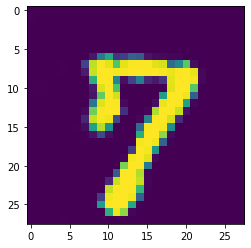

In [15]:
index = 7

samples_test = np.random.normal(0, 1, (1, 100))
labels_test = np.array([int(index)]).reshape((-1, 1))
results = g_model.predict([samples_test, labels_test])
plt.imshow(results[0].reshape(28, 28))

### Inference by loading model weights

In [5]:
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

def num_to_img(index):
    generator = keras.models.load_model(r'C:\Users\Admin\Documents\cgan\working\G_MODEL_NAME.keras',compile=False)
    samples_test = np.random.normal(0, 1, (1, 100))
    labels_test = np.array([int(index)]).reshape((-1, 1))
    results = generator.predict([samples_test, labels_test])
    plt.imshow(results[0].reshape(28, 28))

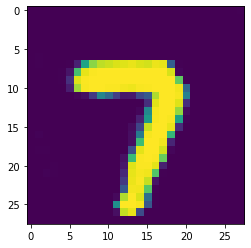

In [7]:
num_to_img(7)